In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

#### Generate Analysis: Human-In-The-Loop

In [2]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

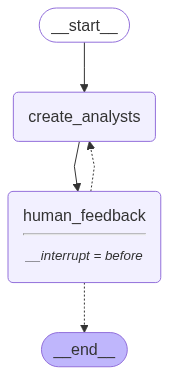

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts}, 
    thread, 
    stream_mode="values"
    ):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI performance in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of using LangGraph as an agent framework. He is concerned with issues such as data privacy, bias in AI decision-making, and the societal impact of deploying advanced AI systems.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Solutions Consultancy
Role: Business Strategy Consultant
Description: Ms. Thompson analyzes the business benefits of adopting LangGraph, focusing on cost efficiency, improved productivit

In [5]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [6]:
# We now update the state as if we are the human_feedback node
graph.update_state(
    thread, 
    {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"}, 
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0826a1-671a-6e86-8002-2202dbc6bab0'}}

In [7]:
# Continue the graph execution
for event in graph.stream(
    None, 
    thread, 
    stream_mode="values"
):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI performance in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of using LangGraph as an agent framework. He is concerned with issues such as data privacy, bias in AI decision-making, and the societal impact of deploying advanced AI systems.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Solutions Consultancy
Role: Business Strategy Consultant
Description: Ms. Thompson analyzes the business benefits of adopting LangGraph, focusing on cost efficiency, improved productivit

In [8]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(
    thread, 
    {"human_analyst_feedback": further_feedack}, 
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0826a1-a783-6dce-8004-408208936137'}}

In [9]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [10]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [11]:
final_state.next

()

In [12]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alice Johnson
Affiliation: Tech Innovators Inc.
Role: AI Researcher
Description: Alice focuses on the technical advantages of LangGraph, exploring its capabilities in enhancing AI model performance and integration. She is particularly interested in how LangGraph can streamline workflows and improve the efficiency of AI agents.
--------------------------------------------------
Name: Michael Chen
Affiliation: Startup Hub
Role: Entrepreneur
Description: Michael represents the startup perspective, emphasizing the agility and scalability that LangGraph offers to new businesses. He is keen on how adopting this framework can provide startups with a competitive edge in developing AI-driven solutions.
--------------------------------------------------
Name: Dr. Sarah Patel
Affiliation: Data Science Institute
Role: Data Analyst
Description: Dr. Patel analyzes the data management and analytical benefits of LangGraph. She is concerned with how the framework can enhance data processing capab

#### Conduct Interview

In [13]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [14]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)
        
    # Write messages to state
    return {"messages": [question]}

#### Generate answer: Parallelization

In [15]:
# Web search tool

# from langchain_community.tools.tavily_search import TavilySearchResults
# tavily_search = TavilySearchResults(max_results=3)

from dotenv import load_dotenv
load_dotenv()

from langchain_tavily import TavilySearch
tavily_search = TavilySearch(max_results=3)

# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [21]:
tavily_search.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Paris',
   'title': 'Paris - Wikipedia',
   'content': 'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi),',
   'score': 0.98536,
   'raw_content': None},
  {'url': 'https://www.coe.int/en/web/interculturalcities/paris',
   'title': 'Paris, France - Intercultural Cities Programme - The Council of Europe',
   'content': 'Paris, France - Intercultural City - Intercultural Cities Programme Council of Europe Human Rights Human Rights Online resources Human Rights Online resources # Intercultural Cities Programme - What is an intercultural city? - Intercultural Regions - Index reports per city - Intercultural profiles 2. Intercultural Cities Programme 4. Paris # Paris, France - Intercultural City Paris is the capital and most populous ci

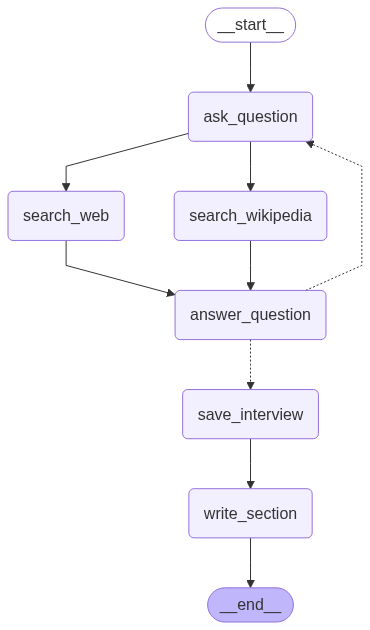

In [22]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    # Search
    search_docs = WikipediaLoader(
        query=search_query.search_query, 
        load_max_docs=2
    ).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(
    state: InterviewState, 
    name: str = "expert"
):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
        
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question', 'save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [23]:
print(analysts[0])

affiliation='Tech Innovators Inc.' name='Alice Johnson' role='AI Researcher' description='Alice focuses on the technical advantages of LangGraph, exploring its capabilities in enhancing AI model performance and integration. She is particularly interested in how LangGraph can streamline workflows and improve the efficiency of AI agents.'


In [24]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke(
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, 
    thread
)
Markdown(interview['sections'][0])

## Unleashing AI Potential: The Technical Advantages of LangGraph

### Summary
LangGraph is emerging as a transformative framework for AI agent development, offering a unique approach that diverges from traditional linear coding methods. By enabling developers to construct agent behaviors visually, LangGraph simplifies the creation of complex workflows, making it particularly advantageous for tasks that require multi-step reasoning and conditional logic. This graphical interface not only enhances usability but also allows for the integration of advanced features such as short-term and long-term memory storage, human-in-the-loop interactions, and fault tolerance, which are critical for building robust AI systems [1][2].

One of the most compelling insights from recent discussions is LangGraph's orchestration capabilities. It provides a reliable layer that allows developers to control the context that reaches their language models (LLMs), addressing common challenges in production environments. This orchestration is vital for ensuring that AI agents can operate effectively in real-world scenarios, where data persistence and error handling are paramount [2]. Furthermore, LangGraph's modular design facilitates the management of intricate scenarios, making it easier to implement multi-agent systems that can collaborate and share information seamlessly [1][3].

Interestingly, LangGraph's visual programming approach not only streamlines the development process but also democratizes access to AI development. By lowering the barrier to entry, it empowers a broader range of users, including those without extensive programming backgrounds, to engage in AI agent creation. This shift could lead to a surge in innovative applications across various sectors, from education to business intelligence [1][4].

In summary, LangGraph stands out for its ability to enhance AI model performance and integration through its user-friendly interface and robust orchestration features. As organizations increasingly seek to leverage AI for complex tasks, LangGraph's capabilities position it as a leading choice for developers aiming to build efficient and effective AI agents.

### Sources
[1] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[2] https://blog.langchain.com/how-to-think-about-agent-frameworks/  
[3] https://oxylabs.io/blog/langgraph-vs-langchain  
[4] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  

#### Parallelize interviews: Map-Reduce

In [28]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

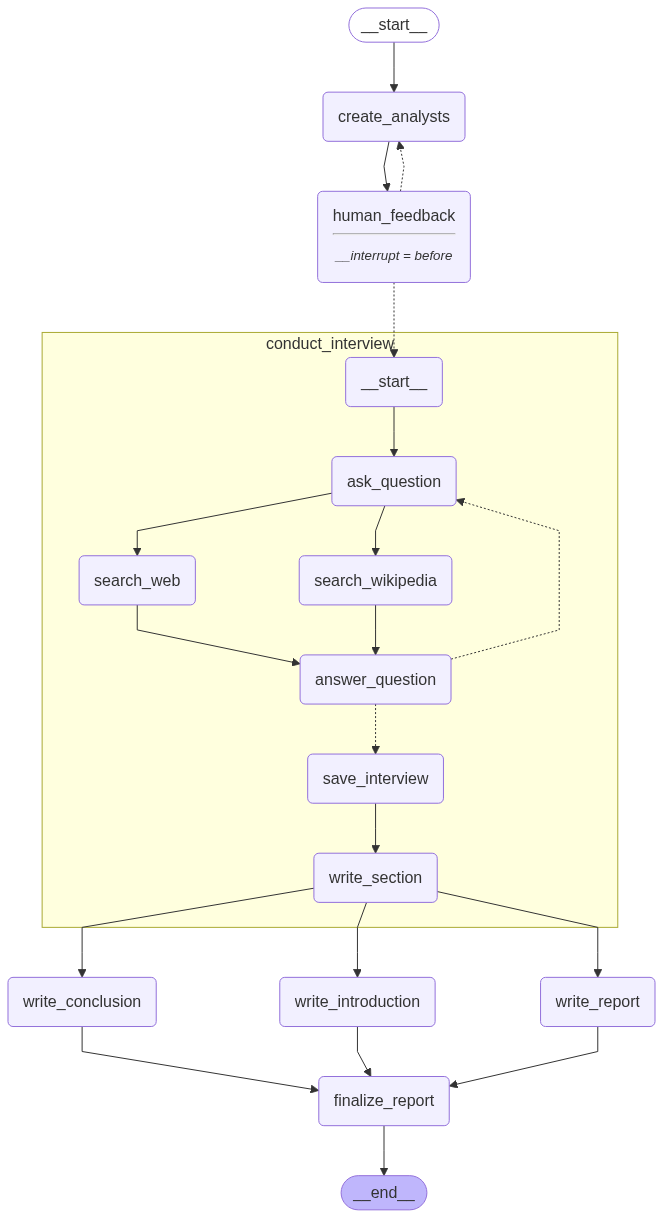

In [31]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview", 
                {
                    "analyst": analyst,
                    "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
                }
            ) for analyst in state["analysts"]
        ]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    {
        "topic": topic,
        "max_analysts": max_analysts
    }, 
    thread, 
    stream_mode="values"
):  
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on 

In [33]:
# We now update the state as if we are the human_feedback node
graph.update_state(
    thread, 
    {"human_analyst_feedback": "Add in the CEO of gen ai native startup"}, 
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08297c-9640-60ac-8002-8c9a1e19cbe4'}}

In [34]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on 

In [35]:
# Confirm we are happy
graph.update_state(
    thread, 
    {"human_analyst_feedback": None}, 
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08297d-57bc-60fa-8004-ccbad71eebe3'}}

In [36]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [37]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unlocking the Future of AI Development with LangGraph

## Introduction

In the fast-paced world of generative AI, the need for efficient and adaptable frameworks is paramount. LangGraph emerges as a transformative solution, enabling developers to streamline AI agent development through a visual, graph-based interface. This report explores the multifaceted benefits of adopting LangGraph, including its ability to manage complex workflows, enhance decision-making capabilities, and facilitate human-in-the-loop interactions. By comparing LangGraph with traditional frameworks, we highlight its competitive edge in scalability and user-friendliness. As startups seek innovative solutions, LangGraph stands out as a powerful ally in harnessing the full potential of AI technology.

---


The adoption of LangGraph as an agent framework presents numerous advantages for developers and businesses looking to enhance their AI capabilities. LangGraph distinguishes itself through its innovative graphical interface, which allows for the visual construction of complex agent behaviors, moving away from traditional linear coding methods. This approach not only simplifies the development process but also enables the management of intricate multi-step tasks and dynamic decision-making processes, essential for modern AI applications [1][2].

One of the key benefits of LangGraph is its support for cyclic workflows, which are vital for agents that need to adapt based on real-time data and feedback. This capability enhances the efficiency and robustness of AI applications, particularly in scenarios requiring multi-agent collaboration and persistent workflows [1][2]. The framework's architecture, built on agent abstractions, provides both declarative and imperative APIs, facilitating the creation of production-ready systems that require fine-grained control over agent thought processes [2][3].

LangGraph's user-friendly design caters to a broader audience, allowing users with limited technical backgrounds to create effective workflows without compromising functionality. This democratization of AI development is further supported by the standardization of critical components such as memory and human-in-the-loop capabilities, which streamline the development process and enhance the overall user experience [3][4]. The integration of human-in-the-loop workflows allows for designated points of human review, ensuring accuracy and oversight in applications where these factors are paramount [1][6].

The recent launch of LangGraph has been met with enthusiasm, as it incorporates valuable lessons from its predecessor, LangChain, while offering a low-level, controllable architecture that appeals to developers seeking flexibility [4]. The framework's ability to support various agent patterns, including basic prompt chaining and parallelization, enhances its appeal for businesses aiming to implement effective AI solutions [5]. 

Moreover, competitive analysis highlights LangGraph's strengths in real-world applications, such as developing stock analysts capable of making investment recommendations, showcasing its potential to deliver tangible business benefits [6]. The graph-based architecture of LangGraph not only provides transparency in agent workflows but also simplifies debugging and enhances scalability, making it an attractive option for startups and established businesses alike [4][5].

In summary, LangGraph represents a significant advancement in AI agent development, offering a versatile framework that streamlines the creation of intelligent applications while enhancing their capabilities. Its combination of scalability, user-friendliness, and robust functionality positions it as a leading choice for developers and businesses looking to leverage generative AI for innovative solutions.


---

## Conclusion

In conclusion, adopting LangGraph as an agent framework offers significant advantages for startups and businesses aiming to enhance their AI capabilities. Its innovative graphical interface streamlines the development process, allowing for the creation of complex, dynamic workflows that traditional coding methods struggle to manage. The framework's support for cyclic workflows, human-in-the-loop interactions, and modular design empowers developers to build robust, scalable AI agents that can adapt to real-time data. Furthermore, LangGraph's competitive edge lies in its user-friendly approach and integration with existing technologies, making it a compelling choice for organizations looking to leverage generative AI for strategic innovation. As the AI landscape continues to evolve, LangGraph stands out as a pivotal tool for driving efficiency and decision-making in diverse applications.

## Sources
[1] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[2] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326  
[3] https://oxylabs.io/blog/langgraph-vs-langchain  
[4] https://www.ibm.com/think/topics/langgraph  
[5] https://aws.amazon.com/blogs/machine-learning/advanced-tracing-and-evaluation-of-generative-ai-agents-using-langchain-and-amazon-sagemaker-ai-mlflow/  
[6] https://www.amplework.com/blog/langgraph-vs-autogen-vs-crewai-multi-agent-framework/